## Defino bra y kets

$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

# Tutorial: Parent Hamiltonian

Here we are going to develop an overview of the parent hamiltonian code in order to understand the workflow. 

In [ ]:
import numpy as np

In [ ]:
np.random.seed(seed = 1)
depth = 3

In [ ]:
# These will be the angles for the ansatz
angle_list = np.random.rand(depth*2)*2*np.pi
print("Answer_angle_list: ", angle_list)

# 1. The Ansatz

In the original paper they use following ansatz for creating the parent hamiltonian:

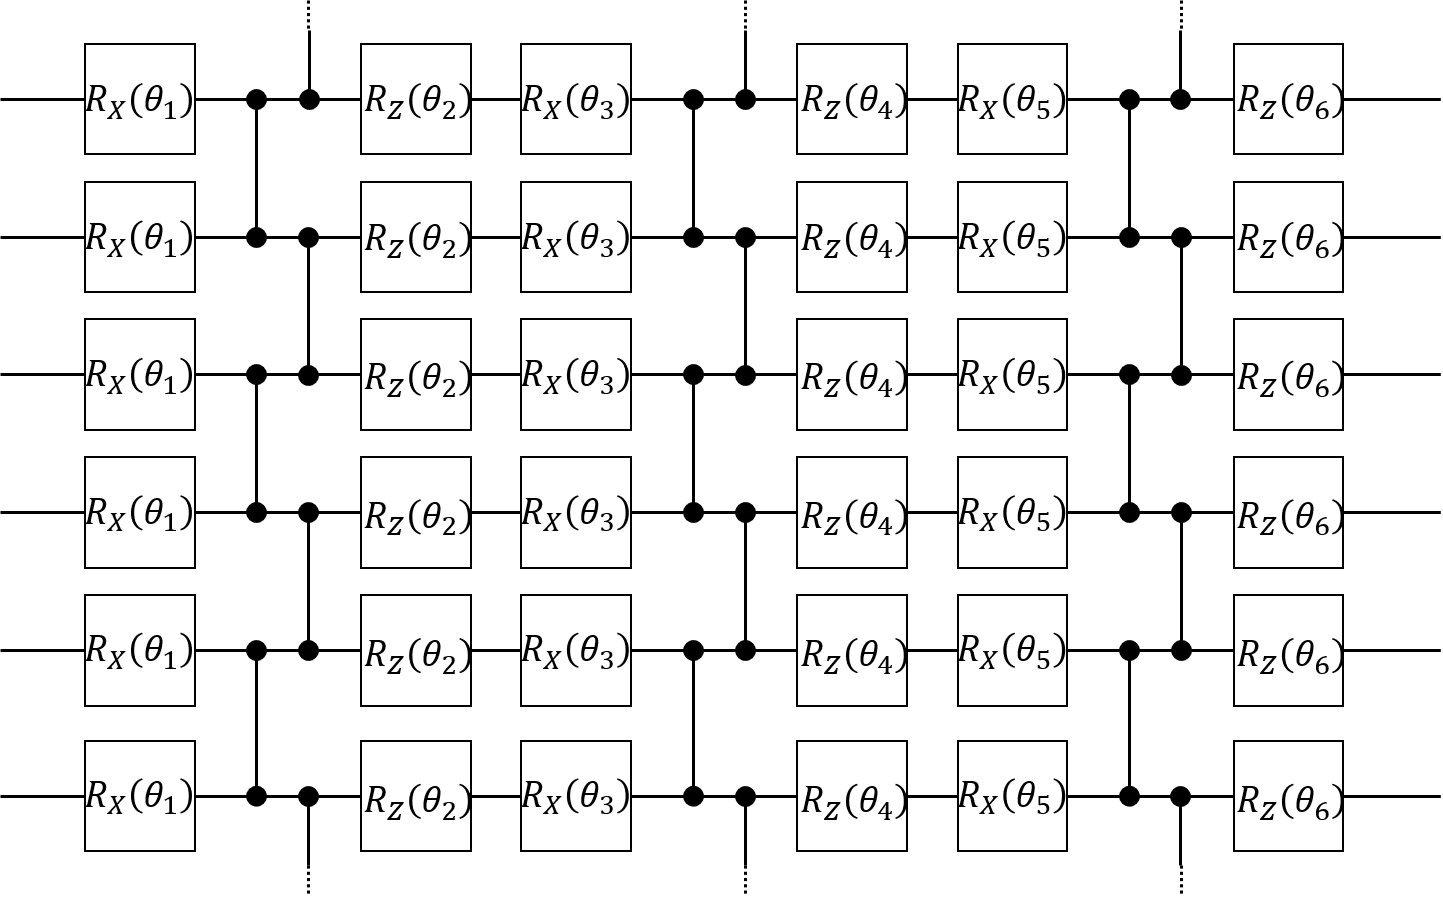

The first problem is to transform the ansatz to a **Matrix Product State** (MPS).


## 2. Gates and Functions for the Ansatz

### Rotation Gates

For computing the MPS of the ansatz the original japanese package have some numpy implementations of several rotation gates. The sign convention of several of these gates are not the same that in **QLM**. Following changes were done in the original japanese package for avoiding mismatch between numpy and **QLM** implementations:

1. $R_x(\theta)$. For adapting the code to **QLM** we have changed the original paper gate for the correspondent **QLM** gate (*x_rotation* in the package)

$$
R_x^{Parent} = 
\begin{equation}
    \begin{pmatrix}
    \cos{\left(\frac{\theta}{2}\right)} & i\sin{\left(\frac{\theta}{2}\right)}\\
    i\sin{\left(\frac{\theta}{2}\right)} & \cos{\left(\frac{\theta}{2}\right)}
    \end{pmatrix}
\rightarrow
R_x^{QLM} = 
    \begin{pmatrix}
    \cos{\left(\frac{\theta}{2}\right)} & -i\sin{\left(\frac{\theta}{2}\right)}\\
    -i\sin{\left(\frac{\theta}{2}\right)} & \cos{\left(\frac{\theta}{2}\right)}
    \end{pmatrix}
\end{equation}
$$

2. $R_z(\theta)$. For adapting the code to **QLM** we have changed the original paper gate for the correspondent **QLM** gate (*z_rotation* in the package)

$$
R_z^{Parent} = 
\begin{equation}
    \begin{pmatrix}
    e^{i\frac{\theta}{2}} & 0\\
    0 & e^{-i\frac{\theta}{2}}
    \end{pmatrix}
\rightarrow
R_z^{QLM} = 
    \begin{pmatrix}
    e^{-i\frac{\theta}{2}} & 0\\
    0 & e^{i\frac{\theta}{2}}
    \end{pmatrix}
\end{equation}
$$

The implementation of this gates were done as numpy array in matrix form so they adapt properly to the MPS formulation. 


### C-Z gate in MPS

The last gate that appear is the *controlled-Z* gate ($cZ$).

$$cZ =  
\begin{equation}
    \begin{pmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & -1
    \end{pmatrix}
\end{equation}
$$

In order to use MPS and **Tensor Networks** (TN) formulation we need to pass the $cZ$ to a tensor notation: $cZ \rightarrow cZ_{ijkl}\;\; i,j,k,l = \{0,1\}$.

$$cZ_{ijkl} = \delta_{ik}\delta_{jl} - 2 \delta_{ijkl}^{1111}$$

Basically: $cZ_{0000}=1 \; cZ_{0101}=1 \; cZ_{1010}=1 \; cZ_{1111} = -1$ And $0$ elsewhere.

In order to program the circuit using a proper MPS decomposition we need only tensors of rank 2 or 3, so we need to transform th $cZ$ gate (that is a matrix but can be rethough as 4-rank tensor) in more appropiated way. 

There are different options for doing the decomposition but in the code following smart way was selected:

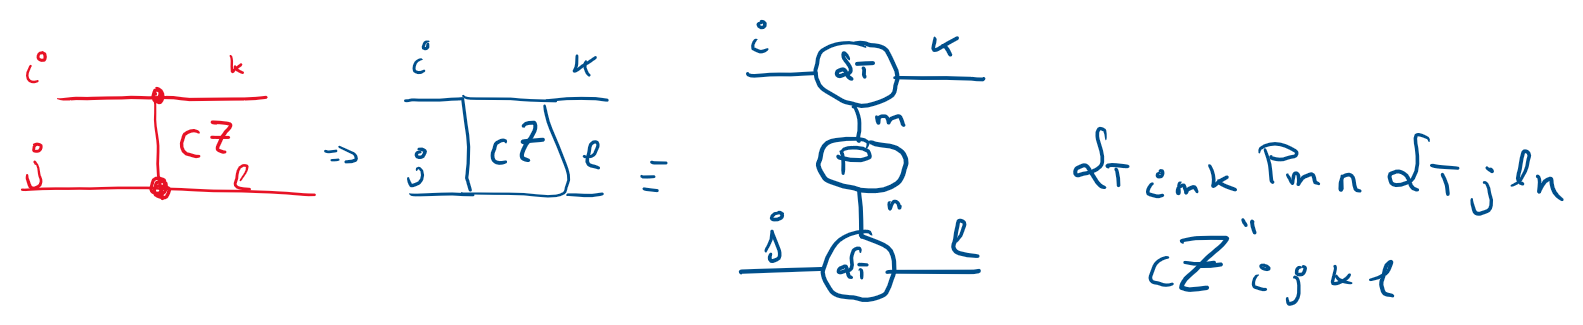


Where:

1. $\delta T$ is the following 3-rank tensor (we call *delta Tensor* and can be built using *deltatensor* function of the package):

$$\delta T_{ijk} = \delta_{i0}\delta_{j0}\delta_{k0} + \delta_{i1}\delta_{j1}\delta_{k1}$$

So only $i=j=k=0$ and $i=j=k=1$ are $1$ and the others are $0$

2. $P$ is the change phase gate (*phasechange_gate* function in the package)

$$
P =  
\begin{equation}
    \begin{pmatrix}
    1 & 1 \\
    1 & -1
    \end{pmatrix}
\end{equation}
$$


### Index Convention

We have created  a python library called **parent_hamiltonian** where all the functions were implemented and ordered in different packages. 

The original paper functions were stored under the package *parent_hamiltonian* of the **parent_hamiltonian/japanese** module. This package have all the coded as presented in the original github of the paper. 

I have rewrite the ansatz part bechause the original index convention from the original japanese package was very confusing so I adapt to a more occidental way. This can be located under the package *ansatz_mps* of the **parent_hamiltonian/ansatz** module.


In [ ]:
import parent_hamiltonian.japanese.parent_hamiltonian as parent
import parent_hamiltonian.ansatz.ansatz_mps as ansatz

## 3. Function for generating 1-qubit MPS

With the different function implementations presented we can develop the MPS of 1-qbit of the circuit. As can be seen this circuit will be a 7-rank tensor (each free index go from 0 to 1). The **one_qubit_d3_ansatz_unit** function from **parent_hamiltonian/japanese/parent_hamiltonian** package allows to built the correspondent MPS. This functions creates the different contractions between the different tensors that build the MPS. 

For the part of the qubit that controls a Z gate over a second qbit the decomposition will be a *delta Tensor* and a $P$ gate. This is a 3-rank tensor.

Meanwhile for the part of the qbit that receives the Z gate controlled by another qubit we only use the *delta Tensor*:

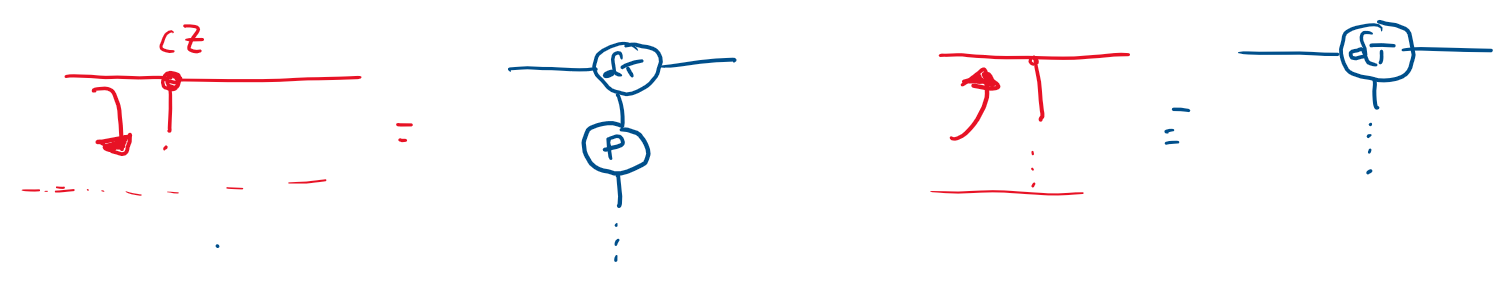

The arrows in the figure explicit the direction of the control


In [ ]:
#Here we create basis blocks in MPS for 1 qubit of the ansatz
x_rot0 = parent.x_rotation(angle_list[0])
z_rot0 = parent.z_rotation(angle_list[1])
x_rot1 = parent.x_rotation(angle_list[2])
z_rot1 = parent.z_rotation(angle_list[3])
x_rot2 = parent.x_rotation(angle_list[4])
z_rot2 = parent.z_rotation(angle_list[5])
phase_change_gate = parent.phasechange_gate()
delta_tensor = parent.deltatensor()
zeroket = parent.zero_ket()

### Unit 0

Here we depicted the 2 index convetions

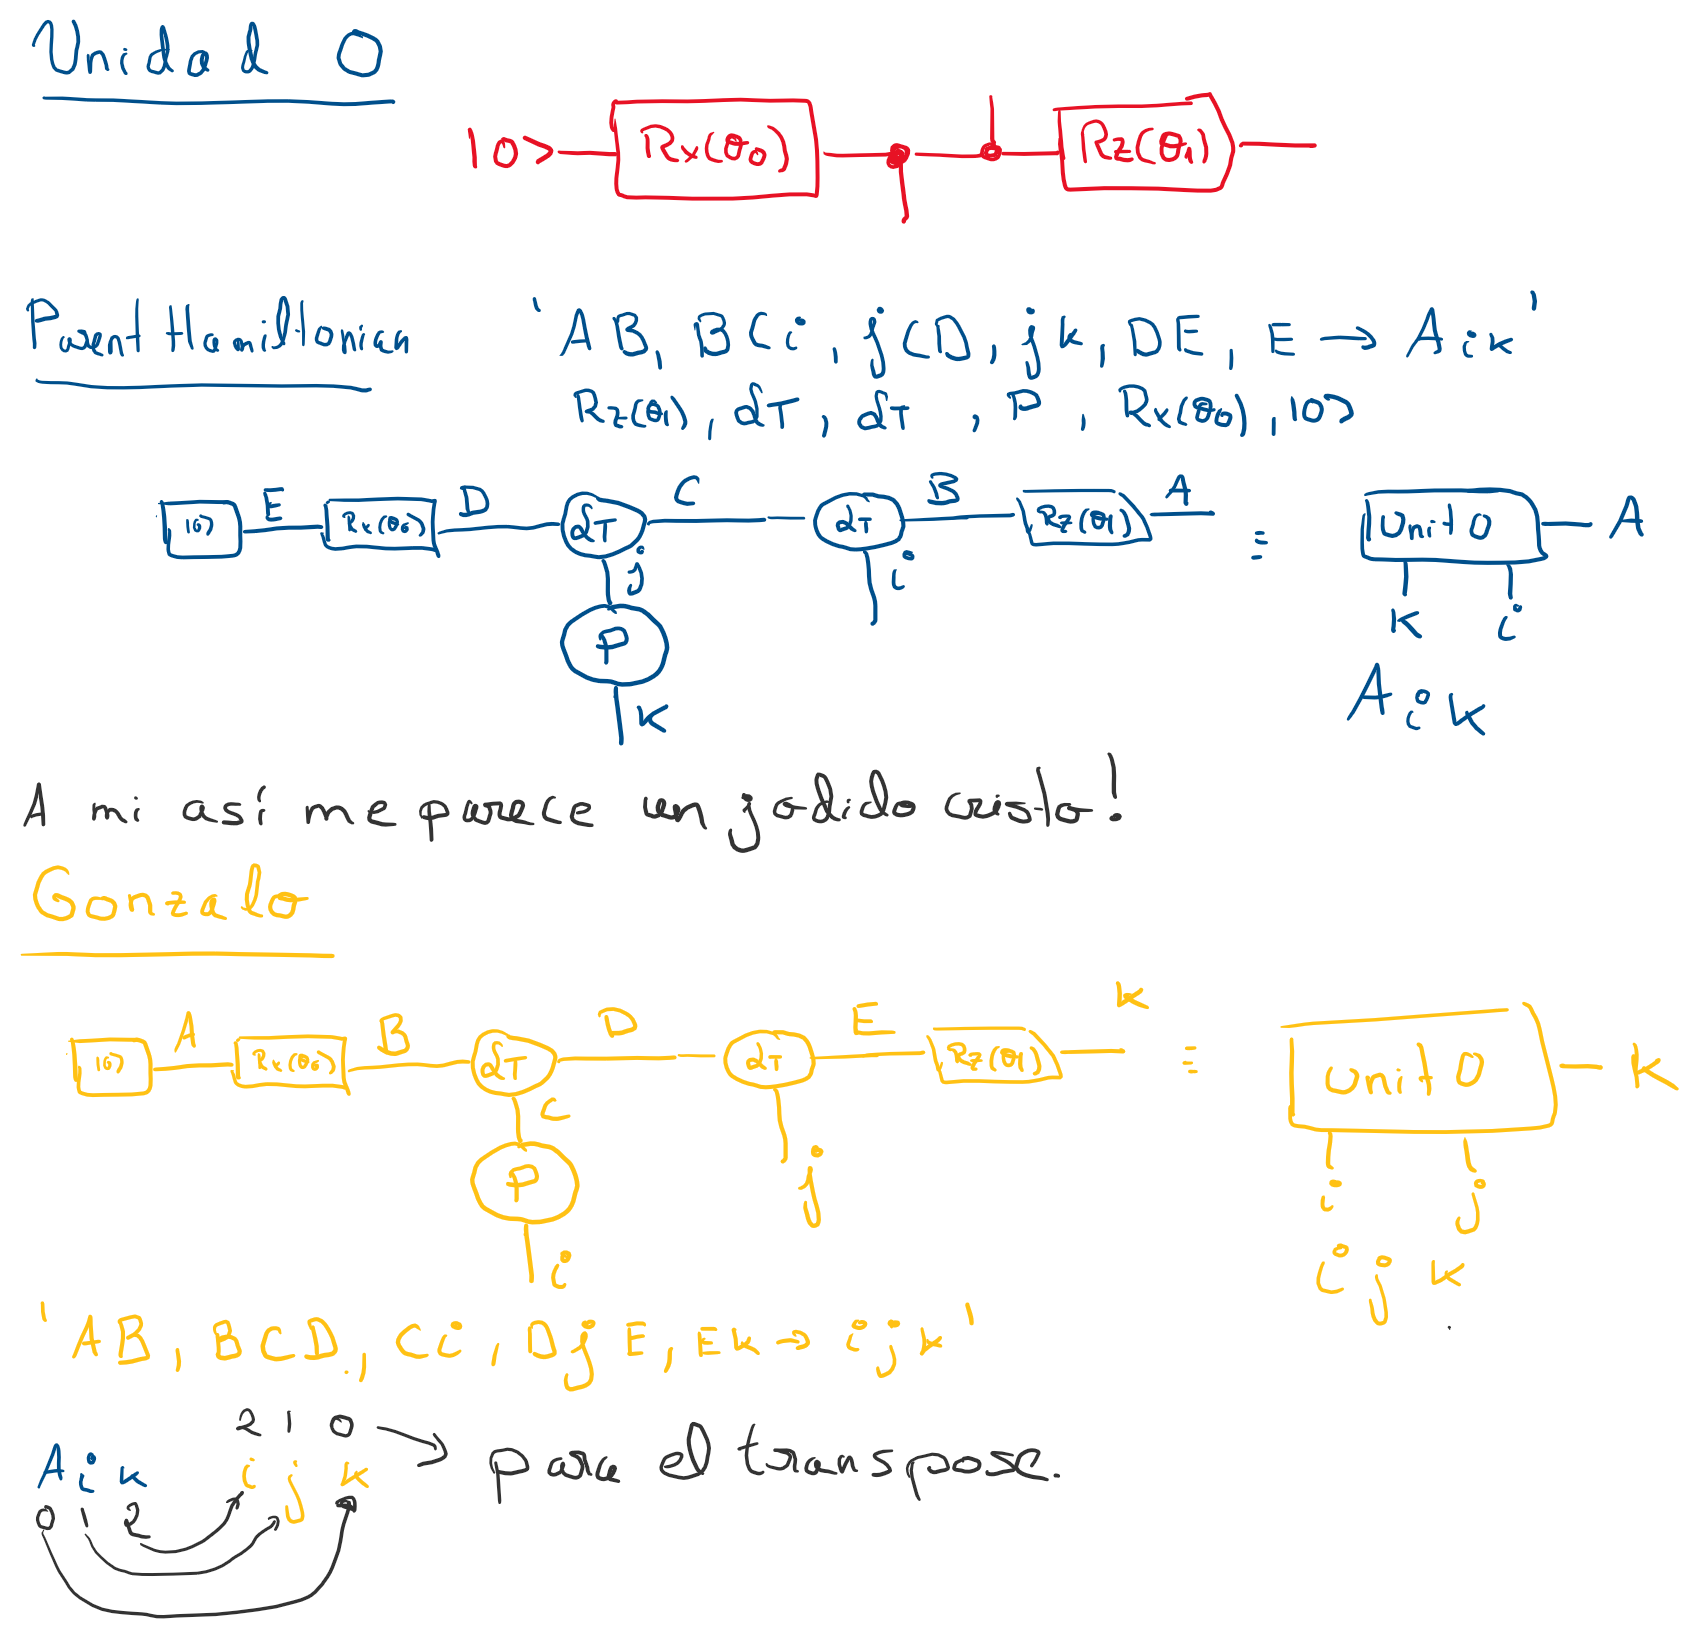

In [ ]:
unit0_ph = np.einsum(
    'AB, BCi, jCD, jk, DE, E -> Aik',
    z_rot0, delta_tensor, delta_tensor, phase_change_gate, x_rot0, zeroket
)

unit0_z = np.einsum(
    'A, AB, BCD, Ci, DjE, Ek -> ijk',
    zeroket, x_rot0, delta_tensor, phase_change_gate, delta_tensor, z_rot0
)

# test both methods are equal
(unit0_ph.transpose((2,1,0)) == unit0_z).all()

### Unit 1

We depicted the 2 index conventions 

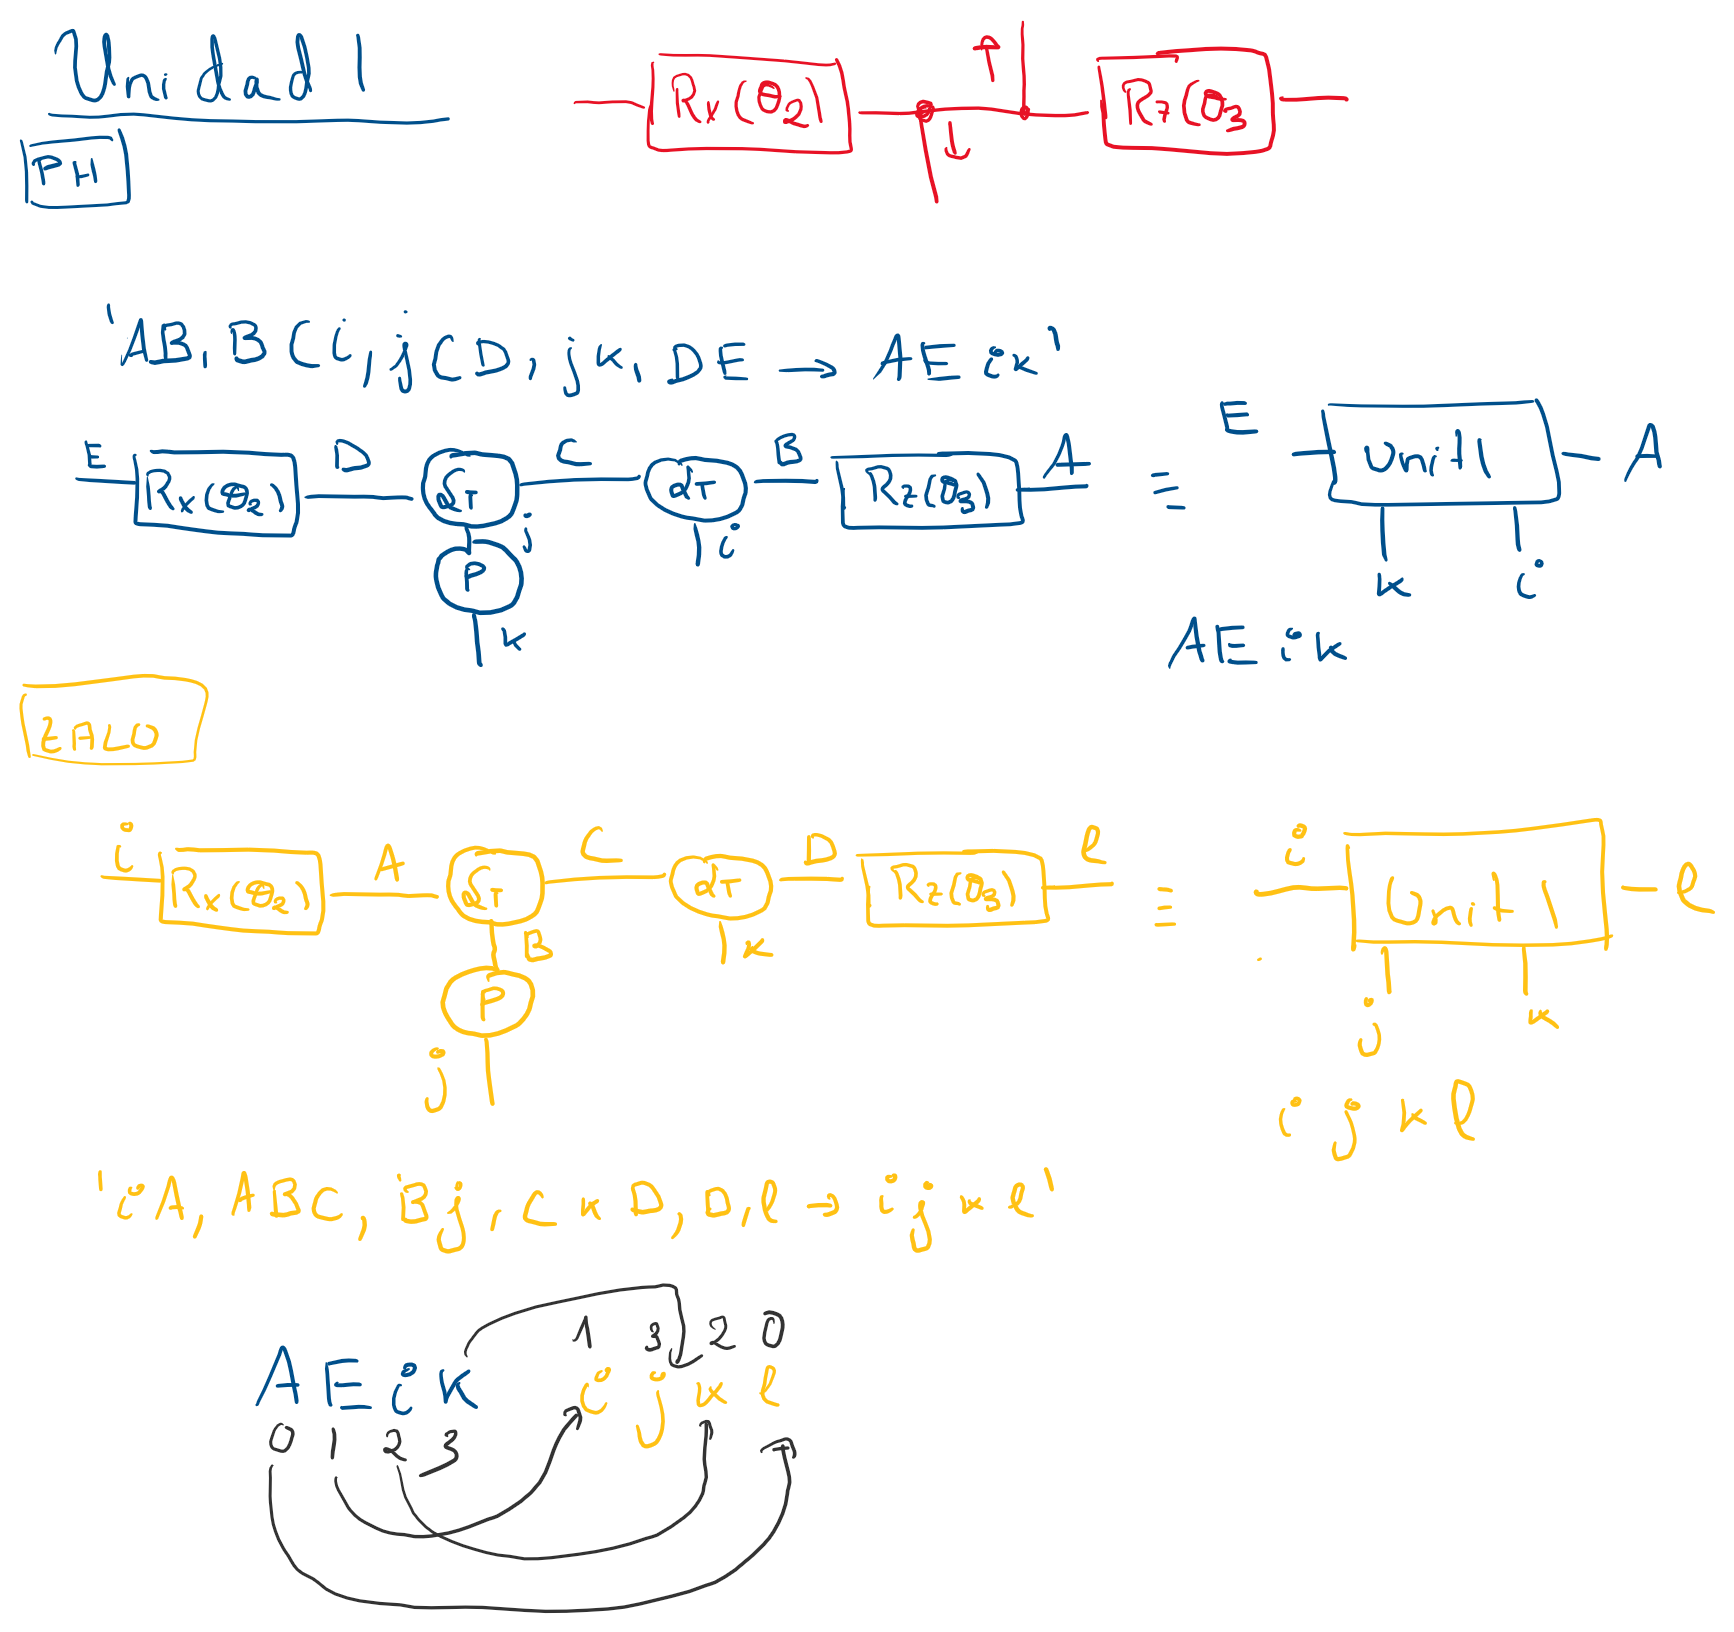

In [ ]:
unit1_ph = np.einsum(
    'AB, BCi, jCD, jk, DE -> AEik',
    z_rot1, delta_tensor, delta_tensor, phase_change_gate, x_rot1
)


unit1_z = np.einsum(
    'iA, ABC, Bj, CkD, Dl -> ijkl',
    x_rot1, delta_tensor, phase_change_gate, delta_tensor, z_rot1
)

# test both methods are equal
(unit1_ph.transpose((1, 3, 2, 0)) == unit1_z).all()

In [ ]:
#same that unit1
unit2_ph = np.einsum(
    'AB, BCi, jCD, jk, DE -> AEik',
    z_rot2, delta_tensor, delta_tensor, phase_change_gate, x_rot2
)

unit2_z = np.einsum(
    'iA, ABC, Bj, CkD, Dl -> ijkl',
    x_rot2, delta_tensor, phase_change_gate, delta_tensor, z_rot2
)

# test both methods are equal
(unit2_ph.transpose((1, 3, 2, 0)) == unit2_z).all()

### 1 Qubit Function

We depicted the 2 index conventions for the complete generation of 1 qubit

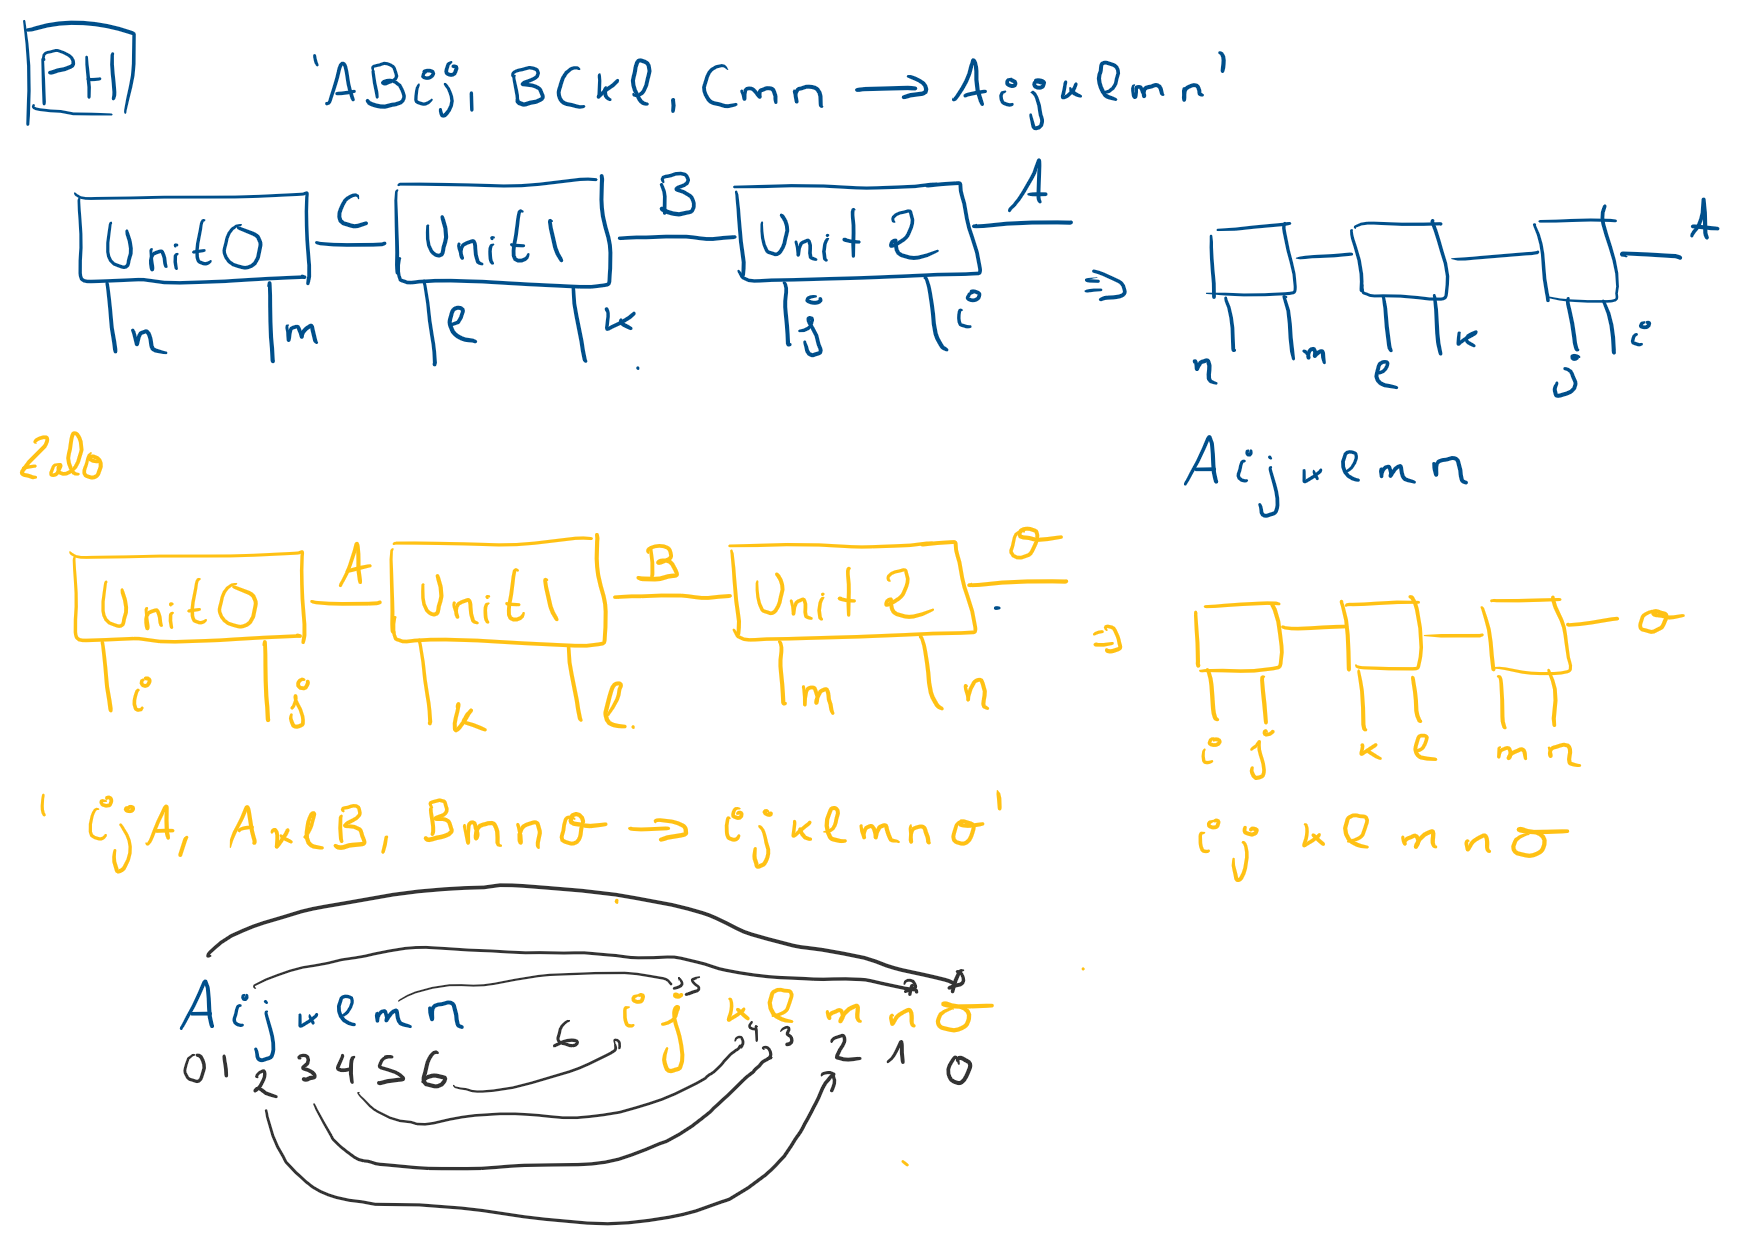

In [ ]:
unit_ph = np.einsum('ABij, BCkl, Cmn -> Aijklmn', unit2_ph, unit1_ph, unit0_ph)
unit_z = np.einsum('ijA, AklB, Bmno -> ijklmno', unit0_z, unit1_z, unit2_z)
# test both methods are equal
np.isclose(unit_ph.transpose((6,5,4,3,2,1,0)), unit_z).all()

In addition the same function **one_qubit_d3_ansatz_unit** was implemented in the **parent_hamiltonian/ansatz/ansatz_mps** package that implements the sumation in a more occidental way

In [ ]:
# Here we compare both implementations
tensor_1qbit = parent.one_qubit_d3_ansatz_unit(
    angle_list[0],
    angle_list[1],
    angle_list[2],
    angle_list[3],
    angle_list[4],
    angle_list[5]
)
tensor_Zqbit = ansatz.one_qubit_d3_ansatz_unit(
    angle_list[0],
    angle_list[1],
    angle_list[2],
    angle_list[3],
    angle_list[4],
    angle_list[5]
)
np.isclose(tensor_1qbit.transpose((6,5,4,3,2,1,0)), tensor_Zqbit).all()

## 4. Function for generating MPS of Ansatz

Now with the aid of the 1 qubit function we can develop the MPS of the ansatz by recusively concatenation as can be seen in following figure

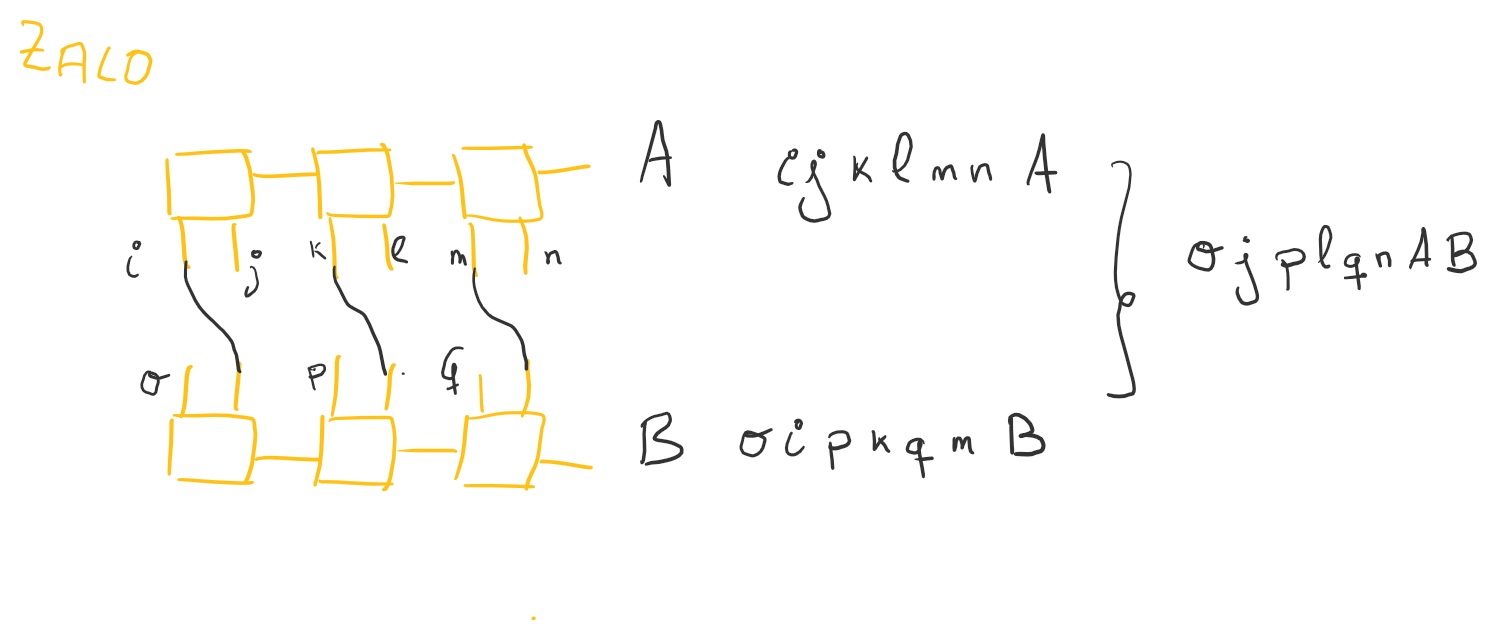

When all qbits are integrated we need to contract following index

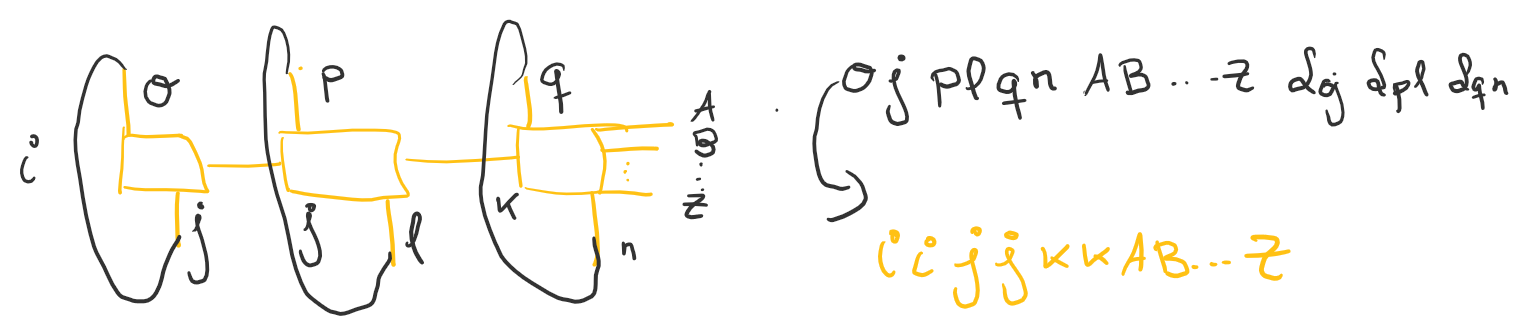

The function for generating the complete ansatz is the same for both packages: *nqubit_mps*. Here we can see how to call it for creating the MPS of the ansatz

In [ ]:
nqubit = 4
jap_ansatz_mps, index_  = parent.nqubit_mps(nqubit, angle_list)

In [ ]:
zal_ansatz_mps, zal_index = ansatz.nqubit_mps(nqubit, angle_list)

In [ ]:
np.isclose(jap_ansatz_mps, zal_ansatz_mps).all()

In [ ]:
index_

In [ ]:
zal_index

## 5. Computing the Parent Hamiltonian

Now we are going to use the original parent hamiltonian functions for testing my implementation. The original functions needed for doing the complete parent hamiltonian implementation are stored in the **parent_hamiltonian/japanese/parent_hamiltonian** package. Here we review the most important functions of the original implementation.

### 5.1 nqubit_state_locality_checker function

This function takes the MPS of the ansatz function and returns the correspondent reduced density matrix whose rank is lower than their correspondent dimension. 

Let $\ket{\Psi} = \sum_{i_1, i_2, \cdots, i_N} \Psi_{i_1, i_2, \cdots, i_N} \ket{i_1, i_2, \cdots, i_N}$ the state of the ansatz with $\Psi_{i_1, i_2, \cdots, i_N}$ the amplitudes in MPS format. The main workflow is the following:

1. They create the reduced density operator for only 2 qubits. So they trace out all qubits except 2:

$$\text{Tr}_{i_3, i_4, \cdots, i_N}(\Psi \Psi^{*}) =\Psi_{i_1, i_2, i_3 \cdots, i_N} \Psi^{*}_{j_1, j_2, i_3 \cdots, i_N} = A$$

2. They transform the reduced density operator in a matrix, compute the rank and compare with the dimension of the matrix.

$$\text{Comparison} = \text{rank}(A) < dim(A)$$


3. If $\text{Comparison}$ is True then the procces is stopped and matrix $A$ is returned. 

4. If $\text{Comparison}$ is False then the loop is started and the reduced density operator for on qubit more is used (so they trace all qbuits except 3).


This procedure is looped for all qubits until condition 2 is satisfied. The function returns:

* Matrix ($A$) of the reduced density operator for $m$ qubits ($m$ can go from 2 to N) which verify their rank is lower than their dimension.
* The rank of the Matrix
* The dimension of the Matrix

We are going to compare the 2 implementations of the ansatz with the original paper functions for testing that all works properly

In [ ]:
jap_ansatz_mps.shape

In [ ]:
jap_ansatz_mps.size

In [ ]:
rho_matrix, rank, local = parent.nqubit_state_locality_checker(
    jap_ansatz_mps, index_, nqubit)
rho_matrix_z, rank_z, local_z = parent.nqubit_state_locality_checker(
    zal_ansatz_mps, zal_index, nqubit)

In [ ]:
# Here we compare the dimension of the original density operator with the Reducity Matrix returned by the function

# |a><a|
original_rho = np.kron(
    jap_ansatz_mps.reshape((jap_ansatz_mps.size, 1)), 
    np.conj(jap_ansatz_mps.reshape((jap_ansatz_mps.size, 1))).T
)

print("Shape of the complete Density matrix for MPS: {}".format(original_rho.shape))
print("Shape of the reduced Density matrix returned by function: {}".format(rho_matrix.shape))

In [ ]:
# Testing both reduced matrix are the same
np.isclose(rho_matrix, rho_matrix_z).all()

In [ ]:
print("rank original: {}".format(rank))
print("rank Zalo: {}".format(rank_z))

In [ ]:
print("local original: {}".format(local))
print("local Zalo: {}".format(local_z))

### 5.2 null_projector function

Over the reduced density matrix returned by *nqubit_state_locality_checker* function the kernel is computed. 

Let $A$ a matrix then the *Kernel* of the matrix is the null space asociated to the $A$ matrix. This is:

$$\text{Ker}(A) = \{\ket{v ^i} / A\ket{v ^i} = 0 \;\; i=0, 1, \cdots, m \;\; \braket{v^i}{v ^j}=\delta_{ij}\}$$



Once the *Kernel* is obtained the projectors over the null space can be built in an easy way:

$$h_{i} = \ket{v^i}\bra{v^i}$$

It can be demonstrated (I do not know how yet)

$$h_i \ket{\Psi} = 0$$

and of course:

$$H=\sum^{m}_{i=0}h_i \; \rightarrow H\ket{\Psi} = 0$$

By construction opertator $H$ is a parent Hamiltonian. 

Again we are going to test that the different ansatz implementations give same results

In [ ]:
null_projector, matrix_size, null_space = parent.null_projector(
    rho_matrix, rank, local)
null_projector_z, matrix_size_z, null_space_z = parent.null_projector(
    rho_matrix_z, rank_z, local_z)

In [ ]:
np.isclose(null_projector, null_projector_z).all()

In [ ]:
print("matrix_size original: {}".format(matrix_size))
print("matrix_size Zalo: {}".format(matrix_size_z))

### 5.3 process_pauliproduct

Now we have constructed an operator $H$ that is a parent Hamiltonian: $H\ket{\Psi} = 0$. Now we need to decompose in the correspondent products of Pauli matrices. 

#### Pauli Matrices for 1 qbit.

The Pauli matrices for 1-qubit are:

$$
\sigma_0 = I = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix},
\sigma_1 = X= \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix},
\sigma_2 = Y= \begin{bmatrix} 0 & -i \\ -i & 0 \end{bmatrix},
\sigma_3 = Z= \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}
$$

$$\sigma_i \sigma_j = \delta_{ij} * \sigma_0$$

The Pauli matrices conforms a basis for matrices of 2x2. This is each 2x2 matrix can be decomposed in matrix pauli form:

$$A = \sum_{i=0}^{4} \alpha_i \sigma_i$$

For computing the coeficients given a matrix $A$ we only need to do:

$$\alpha_i = \frac{\text{Tr} (A \sigma_i)}{2}$$


#### Pauli Matrices for n qbit.

For $n$ qbuits we need to compose for each posible qbuit the 4 Pauli matrices as kronecker products: 

$$\sigma_{i_1} \otimes \sigma_{i_2} \cdots \otimes \sigma_{i_N} \; i_1, i_2, \cdots i_N = 0, 1, 2, 3$$

For a $n$ qbit system the vector will be of dimension $2^n$ and the operators (and density matrices) will be of dimensions ($2^n$, $2^n$). So a complete basis for this kind o matrix will have $4^n$ elements. A complete composition of $n$ Pauli matrix will be a basis for ($2^n$, $2^n$) matrices. So:

$$A = \sum_{i_1, i_2, \cdots ,i_N=0}^{3} \alpha_{i_1, i_2, \cdots ,i_N} \sigma_{i_1} \otimes \sigma_{i_2} \cdots \otimes \sigma_{i_N} \; \text{with} \; dim(A) = (2^n, 2^n)$$

The coeficients can be computed using:

$$ \alpha_{i_1, i_2, \cdots ,i_N} = \frac{\text{Tr} (A \sigma_{i_1} \otimes \sigma_{i_2} \cdots \otimes \sigma_{i_N})}{2^n}$$

#### Pauli Strings

One easy way for representing the composition of Pauli matrices are the Pauli strings that can represent how the pauli matrices are ordered, for example:

"IXZY" will be $\sigma_0 \otimes \sigma_1, \otimes \sigma_3 \otimes \sigma_2 = I \otimes X \otimes Z \otimes Y$


### process_pauliproduct function

Given a matrix this function compute the coefficients and the correspondent Pauli strings for one of the composed Pauli indicated by integer. 

For example if we have a matrix $A$ of 3 qubits we will have a $4^3=64$ element Pauli basis. With this function we can compute the coefficient for a given element of the basis

In [ ]:
#For element 0
h = parent.process_pauliproduct(0, nqubit, local, null_projector)
print(h)
#For element 0
h = parent.process_pauliproduct(35, nqubit, local, null_projector)
print(h)

For creating the complete list of hamiltonian terms we need to iterate over all posible element of the Pauli composed basis

In [ ]:
parallel_list = [parent.process_pauliproduct(i, nqubit, local, null_projector) for i in range(4**local)]
pauliproducts_factor_list = []
for i in range(4**local):
    pauliproducts_factor_list +=parallel_list[i]

In [ ]:
parallel_list_z = [parent.process_pauliproduct(i, nqubit, local_z, null_projector_z) for i in range(4**local_z)]
pauliproducts_factor_list_z = []
for i in range(4**local_z):
    pauliproducts_factor_list_z +=parallel_list_z[i]

In [ ]:
pauliproducts_factor_list_z

In [ ]:
all([h[1] == z[1] for h,z in zip(pauliproducts_factor_list, pauliproducts_factor_list_z)])

In [ ]:
all([np.isclose(h[0], z[0]) for h,z in zip(pauliproducts_factor_list, pauliproducts_factor_list_z)])

## 6. QLM Testing

Finally we can test using QLM if the hamiltonina terms give place to a parent hamiltonian.

First thing is to transform the hamiltonian terms to a propper **QLM** format. 

In [ ]:
from qat.core import Observable, Term
import re

In [ ]:
#We need to change Hamiltonian between ParentHamiltonian and QLM Observables
list_of_terms = []
for pauli in pauliproducts_factor_list:
    step = pauli[1]
    #first we pick the letters
    a=re.findall(r'[A-Z]', step)
    #second we pick the number
    b = re.findall(r'\d+', step)
    #We create the QLM Term object: Term(coefficient, gates, qbits where gates are applied)
    list_of_terms.append(
        Term(pauli[0], ''.join(a), [int(i) for i in b])
    )
#With the list of QLM Terms we create the QLM Observable object
obs = Observable(nqubit, pauli_terms=list_of_terms)

In [ ]:
#We need to change Hamiltonian between ParentHamiltonian and QLM Observables
list_of_terms_z = []
for pauli in pauliproducts_factor_list_z:
    step = pauli[1]
    #first we pick the letters
    a=re.findall(r'[A-Z]', step)
    #second we pick the number
    b = re.findall(r'\d+', step)
    #We create the QLM Term object: Term(coefficient, gates, qbits where gates are applied)
    list_of_terms_z.append(
        Term(pauli[0], ''.join(a), [int(i) for i in b])
    )
#With the list of QLM Terms we create the QLM Observable object
obs_z = Observable(nqubit, pauli_terms=list_of_terms_z)

Now we build the ansatz in a **QLM** program.  For this we are going to use the *ansatz_qlm* package stored in the **parent_hamiltonian/ansatz** module.


In [ ]:
import parent_hamiltonian.ansatz.ansatz_qlm as ansatz_qlm

In [ ]:
qprog = ansatz_qlm.ansatz_qlm(nqubit, depth)

In [ ]:
circuit = qprog.to_circ()

Here we test the qlm implementation is correct in a visual way

In [ ]:
%qatdisplay circuit --svg

### Solving system with QLM

Now we provide the computed Hamiltonian terms to job in **QLM**. The **QLM** job has to be, for this case, in the *Observable* mode (**OBS**)

In [ ]:
#QLM QPUs
from qat.qpus import PyLinalg, CLinalg
qpu = PyLinalg()

In [ ]:
#QLM job from circuit. In Observable Mode!!
job = circuit.to_job('OBS', observable=obs)
#We are going to fix the parameters of the PQC to the ideal ones!!
job_eval = job(** {v: angle_list[i] \
    for i,v in enumerate(job.get_variables())})

In [ ]:
#We submit the job to the QPU
r_eval = qpu.submit(job_eval)

In [ ]:
print("Minimum Energy: {}".format(r_eval.value))

In [ ]:
#QLM job from circuit. In Observable Mode!!
job_z = circuit.to_job('OBS', observable=obs_z)
#We are going to fix the parameters of the PQC to the ideal ones!!
job_z_eval = job_z(** {v: angle_list[i] \
    for i,v in enumerate(job_z.get_variables())})
#We submit the job to the QPU
r_eval_z = qpu.submit(job_z_eval)
print("Minimum Energy: {}".format(r_eval_z.value))

As can be seen the energy is zero for the hamiltonians gotten from different ansatz implementations.